# Actividad de investigación sobre JAX

Esta actividad voluntaria tiene como objetivo descubrir y probar JAX, una librería de Google que surge como alternativa a TensorFlow y PyTorch y que se está empleando actualmente en proyectos de gran envergadura como DeepMind.

> Jairo Andrades Bueno

## 4. Ejemplo práctico: Uso de una red neuronal convolucional para transformar imágenes

Este cuaderno utiliza el dataset CIFAR-10 y aplica ruido en forma de puntos aleatorios de colores a las imágenes. Entrenaremos un autoencoder para restaurarlas.

#### Importación de librerías

In [1]:
# Importamos librerías
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from flax.training import train_state
from jax import random

#### Carga y preparación de Datos
Cargamos el dataset CIFAR-10 y añadimos ruido en forma de puntos aleatorios.

In [2]:
# Cargamos el  CIFAR-10
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
# Función que genera ruido en forma de puntos aleatorios a un array de imágenes
def add_random_noise(images, num_points):
    noisy_images = images.copy()
    for img in noisy_images:
        height, width, _ = img.shape
        for i in range(num_points):
            # Coordenada x
            x = np.random.randint(0, height)
            # Coordenada y
            y = np.random.randint(0, width)
            # Color aleatorio (RGB)
            img[x, y] = np.random.uniform(0, 1, size=3)
    return noisy_images

In [4]:
# Aplica el ruido a los datos
x_train_noisy = add_random_noise(x_train, 300)
x_test_noisy = add_random_noise(x_test, 300)

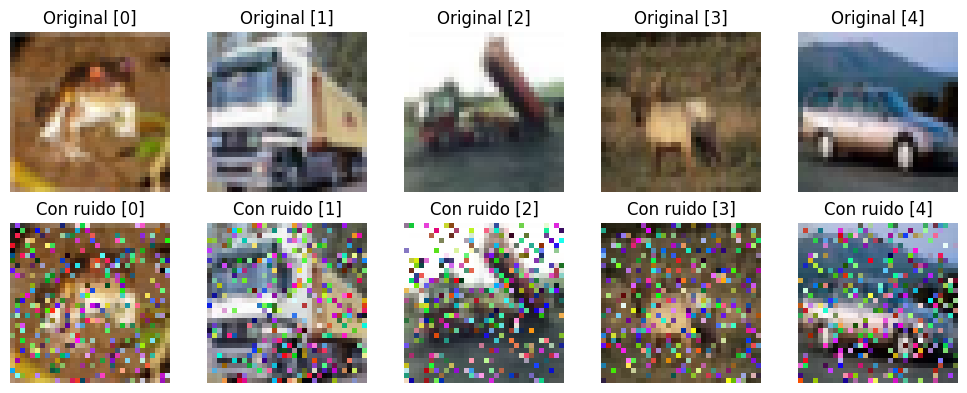

In [5]:
# Muestra algunas imágenes originales y con ruido
n = 5  # Número de imágenes a mostrar
plt.figure(figsize=(10, 4))
for i in range(n):
    # Imagen original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.title(f'Original [{i}]')
    plt.axis('off')

    # Imagen con ruido
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i])
    plt.title(f'Con ruido [{i}]')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Construcción del Autoencoder
Definimos una arquitectura básica de autoencoder para procesar las imágenes.

In [6]:
# Define la clase para el modelo
class Model(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Encoder
        x = nn.relu(nn.Conv(32, (3, 3), padding='SAME')(x))
        x = nn.max_pool(x, (2, 2), padding='SAME')
        x = nn.relu(nn.Conv(32, (3, 3), padding='SAME')(x))
        x = nn.max_pool(x, (2, 2), padding='SAME')

        # Decoder
        x = nn.relu(nn.Conv(32, (3, 3), padding='SAME')(x))
        x = jax.image.resize(x, (x.shape[0], 16, 16, 32), method='bilinear')
        x = nn.relu(nn.Conv(32, (3, 3), padding='SAME')(x))
        x = jax.image.resize(x, (x.shape[0], 32, 32, 32), method='bilinear')
        x = nn.sigmoid(nn.Conv(3, (3, 3), padding='SAME')(x))
        return x

# Inicializa el modelo y el estado de entrenamiento
def create_train_state(rng, learning_rate=1e-3):
    model = Model()
    params = model.init(rng, jnp.ones([1, 32, 32, 3]))
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Función de pérdida y actualización
def loss_fn(params, batch):
    recon = Model().apply(params, batch)
    return jnp.mean((recon - batch) ** 2)

@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, batch)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

#### Entrenamiento del modelo

Entrenamos el modelo con las imágenes con ruido como entrada y las originales como objetivo.

In [7]:
# Entrena el modelo
rng = random.PRNGKey(0)
state = create_train_state(rng)

batch_size = 128
epochs = 10
for epoch in range(epochs):
    loss_accum = 0.0
    for i in range(0, 40000, batch_size):
        batch = x_train_noisy[i:i+batch_size]
        state, loss = train_step(state, batch)
        loss_accum += loss
    print(f'Epoch {epoch+1}, Loss: {loss_accum / (40000 / batch_size)}')

Epoch 1, Loss: 0.03773058205842972
Epoch 2, Loss: 0.031081989407539368
Epoch 3, Loss: 0.029417259618639946
Epoch 4, Loss: 0.028198139742016792
Epoch 5, Loss: 0.027319254353642464
Epoch 6, Loss: 0.026799196377396584
Epoch 7, Loss: 0.0262416023761034
Epoch 8, Loss: 0.02582615800201893
Epoch 9, Loss: 0.025384405627846718
Epoch 10, Loss: 0.025096356868743896


#### Evaluación y visualización de resultados

Usamos el modelo entrenado para restaurar las imágenes con ruido y comparar los resultados.

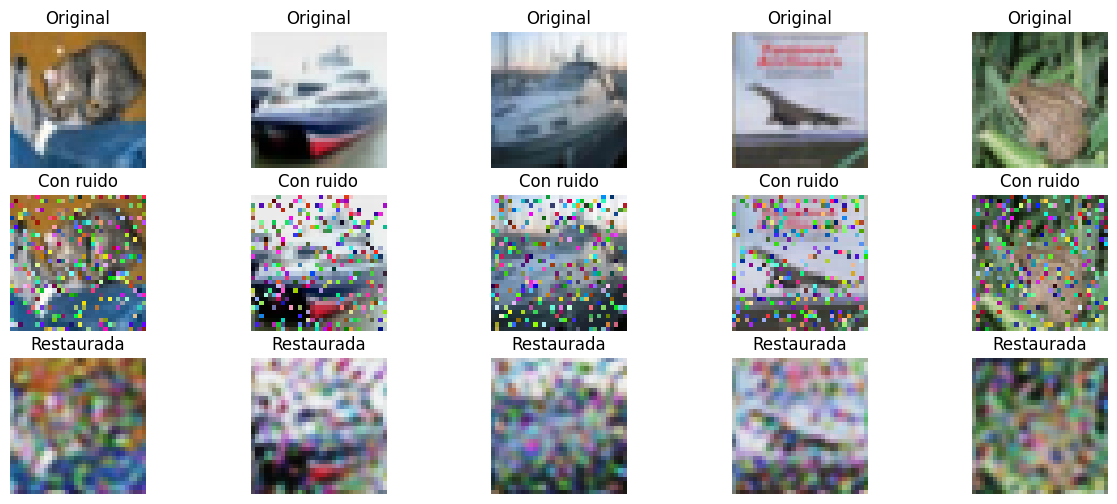

In [8]:
# Restaura las imágenes con ruido
def denoise_images(state, images):
    return Model().apply(state.params, images)

decoded_images = denoise_images(state, x_test_noisy[:5])

# Muestra los resultados
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title("Original")

    plt.subplot(3, 5, i+6)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
    plt.title("Con ruido")

    plt.subplot(3, 5, i+11)
    plt.imshow(decoded_images[i])
    plt.axis('off')
    plt.title("Restaurada")
plt.show()

## Bibliografía

- <https://jax.readthedocs.io/en/latest/quickstart.html>

- <https://es.eitca.org/artificial-intelligence/eitc-ai-gcml-google-cloud-machine-learning/google-cloud-ai-platform/introduction-to-jax/examination-review-introduction-to-jax/what-is-jax-and-how-does-it-speed-up-machine-learning-tasks/>

- <https://geekflare.com/es/google-jax/>

- <https://es.eitca.org/artificial-intelligence/eitc-ai-gcml-google-cloud-machine-learning/google-cloud-ai-platform/introduction-to-jax/examination-review-introduction-to-jax/what-are-the-features-of-jax-that-allow-for-maximum-performance-in-the-python-environment/>

- <https://www.computerworld.es/article/2115282/tensorflow-pytorch-y-jax-los-principales-marcos-de-deep-learning.html>

- <https://www.educative.io/answers/what-is-the-jax-ecosystem>

- <https://www.kaggle.com/code/aakashnain/building-models-in-jax-part1-stax>

- <https://wandb.ai/wandb_fc/tips/reports/How-To-Create-an-Image-Classification-Model-in-JAX-Flax--VmlldzoyMjA0Mjk1>
